In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import Dataset

import torchvision.transforms as transforms
import os
import numpy as np
import matplotlib.pyplot as plt
import random

/home/george-vengrovski/anaconda3/envs/canary-vae/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import os
import numpy as np
import torch
from torch.utils.data import Dataset

class SongDataSet_Image(Dataset):
    def __init__(self, file_dir, num_classes=21, segment_length=370):
        self.file_path = []
        self.num_classes = num_classes
        self.segment_length = segment_length

        for file in os.listdir(file_dir):
            self.file_path.append(os.path.join(file_dir, file))

    def __getitem__(self, index):
        file_path = self.file_path[index]
        data = np.load(file_path, allow_pickle=True)
        spectrogram = data['s']
        ground_truth_labels = data['labels']

        # Convert to tensor
        spectrogram = torch.from_numpy(spectrogram).float().permute(1, 0)  # Bringing spectrogram to length x height
        ground_truth_labels = torch.tensor(ground_truth_labels, dtype=torch.int64).squeeze(0)

        # Convert label to one-hot encoding
        ground_truth_labels = F.one_hot(ground_truth_labels, num_classes=self.num_classes).float()

        return spectrogram, ground_truth_labels 

    def __len__(self):
        return len(self.file_path)

class CollateFunction:
    def __init__(self, segment_length=370):
        self.segment_length = segment_length

    def __call__(self, batch):
        # Unzip the batch (a list of (spectrogram, ground_truth_labels) tuples)
        spectrograms, ground_truth_labels = zip(*batch)

        # Create lists to hold the processed tensors
        spectrograms_processed = []
        ground_truth_labels_processed = []

        # Each sample in batch
        for spectrogram, ground_truth_label in zip(spectrograms, ground_truth_labels):
            # Truncate if larger than context window or take random window
            if spectrogram.shape[0] > self.segment_length:
                start = torch.randint(0, spectrogram.shape[0] - self.segment_length, (1,)).item()
                end = start + self.segment_length
                spectrogram = spectrogram[start:end]
                ground_truth_label = ground_truth_label[start:end]
            elif spectrogram.shape[0] < self.segment_length:
                # Pad with 0s if shorter
                pad_amount = self.segment_length - spectrogram.shape[0]
                spectrogram = F.pad(spectrogram, (0, 0, 0, pad_amount), 'constant', 0)
                ground_truth_label = F.pad(ground_truth_label, (0, 0, 0, pad_amount), 'constant', 0)

            # Append the processed tensors to the lists
            spectrograms_processed.append(spectrogram)
            ground_truth_labels_processed.append(ground_truth_label)

        # Stack tensors along a new dimension
        spectrograms = torch.stack(spectrograms_processed, dim=0)
        ground_truth_labels = torch.stack(ground_truth_labels_processed, dim=0)

        # Final reshape for model
        spectrograms = spectrograms.unsqueeze(1).permute(0, 1, 3, 2)

        return spectrograms, ground_truth_labels


In [3]:
from torch.utils.data import DataLoader

train_dir = "/home/george-vengrovski/Documents/projects/tweety_bert_cluster/project/train"
test_dir = "/home/george-vengrovski/Documents/projects/tweety_bert_cluster/project/test"

train_dataset = SongDataSet_Image(train_dir)
test_dataset = SongDataSet_Image(test_dir)

collate_fn = CollateFunction(segment_length=370)  # Adjust the segment length if needed

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True, collate_fn=collate_fn)


In [4]:
class Conv2dTF(nn.Conv2d):

    PADDING_METHODS = ('VALID', 'SAME')

    """Conv2d with padding behavior from Tensorflow
    adapted from
    https://github.com/mlperf/inference/blob/16a5661eea8f0545e04c86029362e22113c2ec09/others/edge/object_detection/ssd_mobilenet/pytorch/utils.py#L40
    as referenced in this issue:
    https://github.com/pytorch/pytorch/issues/3867#issuecomment-507025011
    used to maintain behavior of original implementation of TweetyNet that used Tensorflow 1.0 low-level API
    """
    def __init__(self, *args, **kwargs):
        # remove 'padding' from ``kwargs`` to avoid bug in ``torch`` => 1.7.2
        # see https://github.com/yardencsGitHub/tweetynet/issues/166
        kwargs_super = {k: v for k, v in kwargs.items() if k != 'padding'}
        super(Conv2dTF, self).__init__(*args, **kwargs_super)
        padding = kwargs.get("padding", "SAME")
        if not isinstance(padding, str):
            raise TypeError(f"value for 'padding' argument should be a string, one of: {self.PADDING_METHODS}")
        padding = padding.upper()
        if padding not in self.PADDING_METHODS:
            raise ValueError(
                f"value for 'padding' argument must be one of '{self.PADDING_METHODS}' but was: {padding}"
            )
        self.padding = padding

    def _compute_padding(self, input, dim):
        input_size = input.size(dim + 2)
        filter_size = self.weight.size(dim + 2)
        effective_filter_size = (filter_size - 1) * self.dilation[dim] + 1
        out_size = (input_size + self.stride[dim] - 1) // self.stride[dim]
        total_padding = max(
            0, (out_size - 1) * self.stride[dim] + effective_filter_size - input_size
        )
        additional_padding = int(total_padding % 2 != 0)

        return additional_padding, total_padding

    def forward(self, input):
        if self.padding == "VALID":
            return F.conv2d(
                input,
                self.weight,
                self.bias,
                self.stride,
                padding=0,
                dilation=self.dilation,
                groups=self.groups,
            )
        elif self.padding == "SAME":
            rows_odd, padding_rows = self._compute_padding(input, dim=0)
            cols_odd, padding_cols = self._compute_padding(input, dim=1)
            if rows_odd or cols_odd:
                input = F.pad(input, [0, cols_odd, 0, rows_odd])

            return F.conv2d(
                input,
                self.weight,
                self.bias,
                self.stride,
                padding=(padding_rows // 2, padding_cols // 2),
                dilation=self.dilation,
                groups=self.groups,
            )

class TweetyNet(nn.Module):
    def __init__(self,
                 num_classes,
                 input_shape=(1, 512, 370),
                 padding='SAME',
                 conv1_filters=32,
                 conv1_kernel_size=(5, 5),
                 conv2_filters=64,
                 conv2_kernel_size=(5, 5),
                 pool1_size=(14, 1),
                 pool1_stride=(14, 1),
                 pool2_size=(14, 1),
                 pool2_stride=(14, 1),
                 hidden_size=512,
                 rnn_dropout=0.,
                 num_layers=1,
                 bidirectional=True,
                 ):
        """initialize TweetyNet model
        Parameters
        ----------
        num_classes : int
            number of classes to predict, e.g., number of syllable classes in an individual bird's song
        input_shape : tuple
            with 3 elements corresponding to dimensions of spectrogram windows: (channels, frequency bins, time bins).
            i.e. we assume input is a spectrogram and treat it like an image, typically with one channel,
            the rows are frequency bins, and the columns are time bins. Default is (1, 513, 88).
        padding : str
            type of padding to use, one of {"VALID", "SAME"}. Default is "SAME".
        conv1_filters : int
            Number of filters in first convolutional layer. Default is 32.
        conv1_kernel_size : tuple
            Size of kernels, i.e. filters, in first convolutional layer. Default is (5, 5).
        conv2_filters : int
            Number of filters in second convolutional layer. Default is 64.
        conv2_kernel_size : tuple
            Size of kernels, i.e. filters, in second convolutional layer. Default is (5, 5).
        pool1_size : two element tuple of ints    specs = self.transform(specs)

            Size of sliding window for first max pooling layer. Default is (1, 8)
        pool1_stride : two element tuple of ints
            Step size for sliding window of first max pooling layer. Default is (1, 8)
        pool2_size : two element tuple of ints
            Size of sliding window for second max pooling layer. Default is (1, 8),
        pool2_stride : two element tuple of ints
            Step size for sliding window of second max pooling layer. Default is (1, 8)
        hidden_size : int
            number of features in the hidden state ``h``. Default is None,
            in which case ``hidden_size`` is set to the dimensionality of the
            output of the convolutional neural network. This default maintains
            the original behavior of the network.
        rnn_dropout : float
            If non-zero, introduces a Dropout layer on the outputs of each LSTM layer except the last layer,
            with dropout probability equal to dropout. Default: 0
        num_layers : int
            Number of recurrent layers. Default is 1.
        bidirectional : bool
            If True, make LSTM bidirectional. Default is True.
        """
        super().__init__()
        self.num_classes = num_classes
        self.input_shape = input_shape

        self.cnn = nn.Sequential(
            Conv2dTF(in_channels=self.input_shape[0],
                     out_channels=conv1_filters,
                     kernel_size=conv1_kernel_size,
                     padding=padding
                     ),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=pool1_size,
                         stride=pool1_stride),
            Conv2dTF(in_channels=conv1_filters,
                     out_channels=conv2_filters,
                     kernel_size=conv2_kernel_size,
                     padding=padding,
                     ),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=pool2_size,
                         stride=pool2_stride),
        )

        # determine number of features in output after stacking channels
        # we use the same number of features for hidden states
        # note self.num_hidden is also used to reshape output of cnn in self.forward method
        batch_shape = tuple((1,) + input_shape)
        tmp_tensor = torch.rand(batch_shape)
        tmp_out = self.cnn(tmp_tensor)
        channels_out, freqbins_out = tmp_out.shape[1], tmp_out.shape[2]
        self.rnn_input_size = channels_out * freqbins_out

        if hidden_size is None:
            self.hidden_size = self.rnn_input_size
        else:
            self.hidden_size = hidden_size

        self.rnn = nn.LSTM(input_size=self.rnn_input_size,
                           hidden_size=self.hidden_size,
                           num_layers=num_layers,
                           dropout=rnn_dropout,
                           bidirectional=bidirectional)

        # for self.fc, in_features = hidden_size * 2 because LSTM is bidirectional
        # so we get hidden forward + hidden backward as output
        self.fc = nn.Linear(in_features=self.hidden_size * 2, out_features=num_classes)

    def forward(self, x):
        features = self.cnn(x)
        # stack channels, to give tensor shape (batch, rnn_input_size, num time bins)
        features = features.view(features.shape[0], self.rnn_input_size, -1)
        # switch dimensions for feeding to rnn, to (num time bins, batch size, input size)
        features = features.permute(2, 0, 1)
        rnn_output, _ = self.rnn(features)
        # permute back to (batch, time bins, hidden size) to project features down onto number of classes
        rnn_output = rnn_output.permute(1, 0, 2)
        logits = self.fc(rnn_output)
        # permute yet again so that dimension order is (batch, classes, time steps)
        # because this is order that loss function expects
        return logits.permute(0, 2, 1)

    def loss_function(self, y_pred, y_true):
        """loss function for TweetyNet
        Parameters
        ----------
        y_pred : torch.Tensor
            output of TweetyNet model, shape (batch, classes, timebins)
        y_true : torch.Tensor
            one-hot encoded labels, shape (batch, classes, timebins)
        Returns
        -------
        loss : torch.Tensor
            mean cross entropy loss
        """
        loss = nn.CrossEntropyLoss()
        return loss(y_pred, y_true)

## TweetyNET FER

In [5]:
model = TweetyNet(num_classes=21, input_shape=(1, 513, 370))
use_gpu = True
device = torch.device("cuda:0" if use_gpu and torch.cuda.is_available() else "cpu")
print(device)
model = model.to(device)

num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print('Number of parameters: %d' % num_params)

optimizer = torch.optim.Adam(params=model.parameters(), lr=1e-3, weight_decay=0.0)

# Training setup
batches_per_eval = 250  # Evaluate after every 100 batches
total_batches = 0  # Total number of batches processed
desired_total_batches = 2e4  # Set your desired total number of batches
total_loss = 0  # Initialize total loss
patience = 4 

cuda:0
Number of parameters: 2703253


In [6]:
# Early stopping parameters
patience = 4  # Number of validations to wait for improvement
num_val_no_improve = 0  # Counter for validations since last improvement
best_val_loss = float('inf')  # Best observed validation loss
stop_training = False  # Flag to stop training

After 250 batches, Training Loss: 1.59e-01, Validation Loss: 3.81e-01, Frame Error Rate: 10.34%
After 500 batches, Training Loss: 9.62e-02, Validation Loss: 3.02e-01, Frame Error Rate: 7.97%
After 750 batches, Training Loss: 6.53e-02, Validation Loss: 3.58e-01, Frame Error Rate: 8.47%
After 1000 batches, Training Loss: 5.32e-02, Validation Loss: 3.00e-01, Frame Error Rate: 7.04%
After 1250 batches, Training Loss: 4.46e-02, Validation Loss: 3.10e-01, Frame Error Rate: 7.36%
After 1500 batches, Training Loss: 3.55e-02, Validation Loss: 3.13e-01, Frame Error Rate: 7.24%
After 1750 batches, Training Loss: 2.99e-02, Validation Loss: 2.90e-01, Frame Error Rate: 6.42%
After 2000 batches, Training Loss: 2.37e-02, Validation Loss: 3.22e-01, Frame Error Rate: 6.64%
After 2250 batches, Training Loss: 1.93e-02, Validation Loss: 3.20e-01, Frame Error Rate: 6.51%
After 2500 batches, Training Loss: 1.87e-02, Validation Loss: 3.51e-01, Frame Error Rate: 6.90%
Early stopping triggered


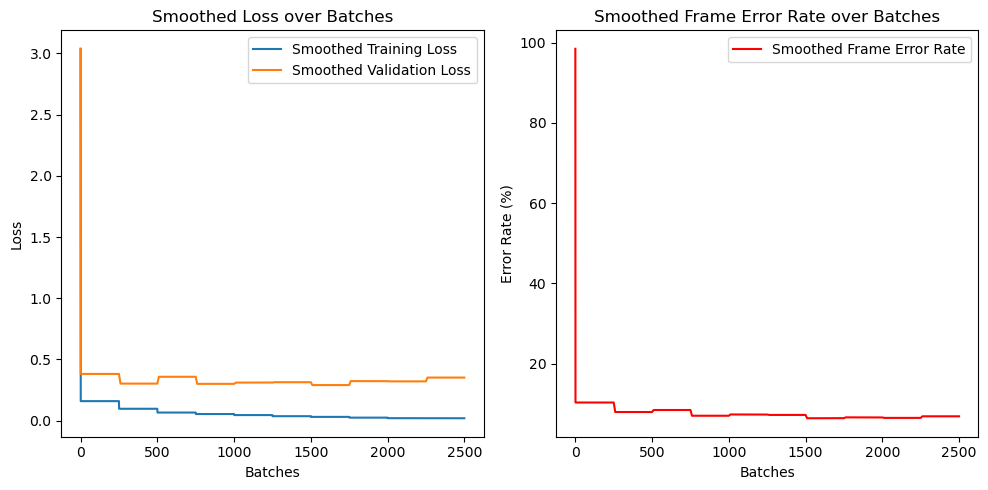

Final smoothed loss after 2750 batches: 0.018695986177772284


In [7]:
def frame_error_rate(y_pred, y_true):
    """
    Compute the frame error rate.
    y_pred: Tensor of shape (batch_size, num_classes, time_steps) - typically the output of a softmax
    y_true: Tensor of shape (batch_size, time_steps) - ground truth labels
    Returns the frame error rate.
    """
    predicted_labels = y_pred.argmax(dim=-2)
    mismatches = (predicted_labels != y_true).float()  # y_true is already in the correct format
    error = mismatches.sum() / y_true.size(0) / y_true.size(1)
    return error * 100

# Modify the validation function to also compute and return the frame error rate
def validate_model(model, test_loader):
    model.eval()
    total_val_loss = 0
    total_frame_error = 0
    num_val_batches = 0
    with torch.no_grad():
        for i, (spectrogram, label) in enumerate(test_loader):
            if i > batches_per_eval:
              break
            spectrogram = spectrogram.to(device)

            label = label.to(device)
            output = model.forward(spectrogram)
            label = label.squeeze(1)
            # Argmax bc CE does not take one hot
            label_indices = label.argmax(dim=-1)
            loss = model.loss_function(y_pred=output, y_true=label_indices)

            total_val_loss += loss.item()
            total_frame_error += frame_error_rate(output, label_indices).item()
            num_val_batches += 1

    return total_val_loss / num_val_batches, total_frame_error / num_val_batches

initial_val_loss, initial_frame_error = validate_model(model, test_loader)

# Initialize lists for storing raw and moving average data
loss_list, val_loss_list, frame_error_rate_list = [initial_val_loss], [initial_val_loss], [initial_frame_error]
loss_buffer, val_loss_buffer, frame_error_buffer = [], [], []

# Training loop

while total_batches < desired_total_batches:
    for i, (spectrogram, label) in enumerate(train_loader):
        if total_batches >= desired_total_batches:
            break

        model.train()

        spectrogram = spectrogram.to(device)

        label = label.to(device)

        output = model.forward(spectrogram)
        label = label.squeeze(1)
        label = label.permute(0,2,1)

        # Argmax bc CE does not take one hot
        label_indices = label.argmax(dim=-2)

        loss = model.loss_function(y_pred=output, y_true=label_indices)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_batches += 1
        loss_buffer.append(loss.item())

        if total_batches % batches_per_eval == 0:
            avg_val_loss, avg_frame_error = validate_model(model, test_loader)

            # Early stopping check
            if avg_val_loss < best_val_loss:
                best_val_loss = avg_val_loss
                num_val_no_improve = 0
            else:
                num_val_no_improve += 1
                if num_val_no_improve >= patience:
                    print("Early stopping triggered")
                    stop_training = True
                    break

            for times in range(batches_per_eval):
                val_loss_buffer.append(avg_val_loss)
                frame_error_buffer.append(avg_frame_error)

                # Calculate dynamic moving averages
                window_size = min(total_batches, 10)  # Use the smaller of total_batches or 10
                loss_list.append(np.mean(loss_buffer[-window_size:]))
                val_loss_list.append(np.mean(val_loss_buffer[-window_size:]))
                frame_error_rate_list.append(np.mean(frame_error_buffer[-window_size:]))

            if loss_list and val_loss_list and frame_error_rate_list:
                print(f'After {total_batches} batches, Training Loss: {loss_list[-1]:.2e}, Validation Loss: {val_loss_list[-1]:.2e}, Frame Error Rate: {frame_error_rate_list[-1]:.2f}%')
        
    if stop_training == True:
        break 

# Plotting the results with moving averages
plt.figure(figsize=(10, 5))

# Loss plot
plt.subplot(1, 2, 1)
plt.plot(loss_list, label='Smoothed Training Loss')
plt.plot(val_loss_list, label='Smoothed Validation Loss')
plt.title('Smoothed Loss over Batches')
plt.xlabel('Batches')
plt.ylabel('Loss')
plt.legend()

# Frame error rate plot
plt.subplot(1, 2, 2)
plt.plot(frame_error_rate_list, label='Smoothed Frame Error Rate', color='red')
plt.title('Smoothed Frame Error Rate over Batches')
plt.xlabel('Batches')
plt.ylabel('Error Rate (%)')
plt.legend()

plt.tight_layout()
plt.show()

print(f"Final smoothed loss after {total_batches} batches: {loss_list[-1]}")

## Calculate FER per syllable

Evaluating: 100%|██████████| 83/83 [00:37<00:00,  2.20batch/s]


Total Frame Error Rate: 6.62%


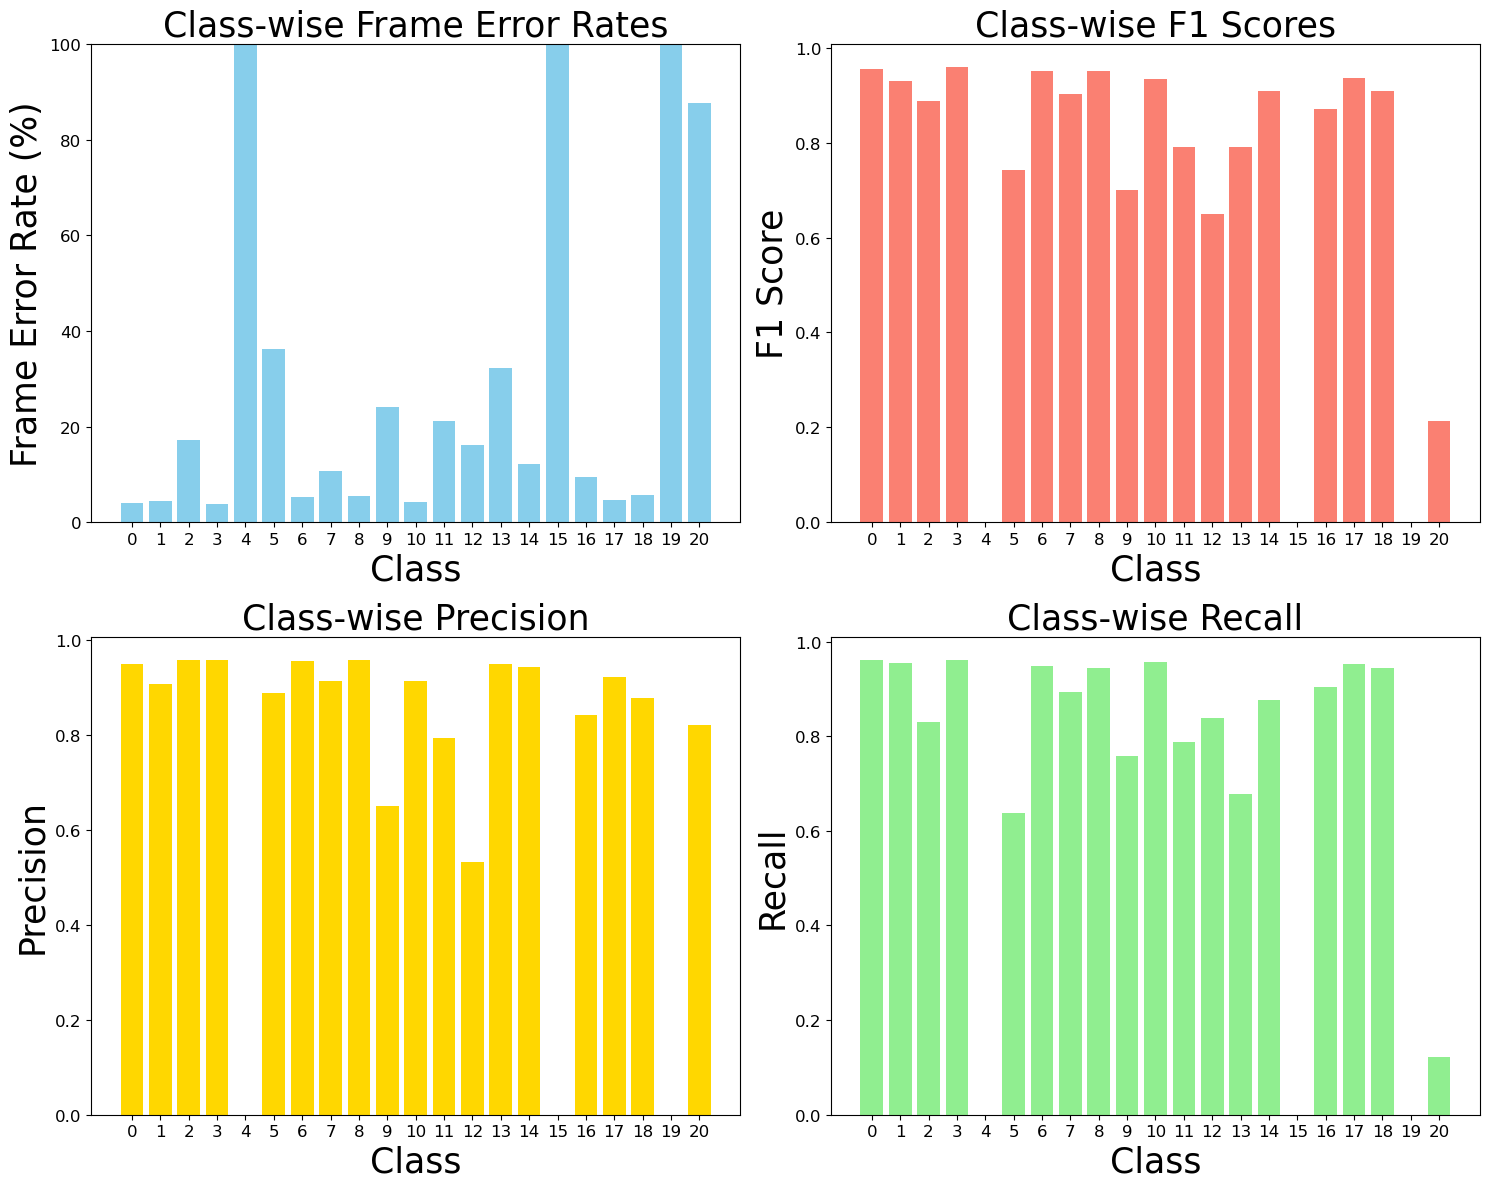

In [8]:
import torch
from collections import defaultdict
from tqdm import tqdm
import matplotlib.pyplot as plt

num_classes = 21  # Update this if the number of classes changes

def validate_model_multiple_passes(model, test_loader, num_passes=1, max_batches=100):
    model.eval()
    # Initialize metrics
    errors_per_class = [0] * num_classes
    correct_per_class = [0] * num_classes
    tp_per_class = [0] * num_classes
    fp_per_class = [0] * num_classes
    fn_per_class = [0] * num_classes
    total_frames = 0
    total_errors = 0

    total_iterations = num_passes * min(max_batches, len(test_loader))
    progress_bar = tqdm(total=total_iterations, desc="Evaluating", unit="batch")

    for _ in range(num_passes):  # Outer loop for multiple passes
        with torch.no_grad():
            for i, (waveform, label) in enumerate(test_loader):
                if i >= max_batches:  # Early stopping condition for each pass
                    break

                waveform = waveform.to(device)
                label = label.to(device)

                output = model.forward(waveform)
                label = label.squeeze(1).permute(0, 2, 1)

                predicted_labels = output.argmax(dim=-2)
                true_labels = label.argmax(dim=-2)

                correct = (predicted_labels == true_labels)
                incorrect = ~correct

                for cls in range(num_classes):  # Iterate over the number of classes
                    class_mask = (true_labels == cls)
                    predicted_class_mask = (predicted_labels == cls)

                    correct_class = correct & class_mask
                    incorrect_class = incorrect & class_mask

                    tp = correct_class.sum().item()
                    fp = (predicted_class_mask & ~class_mask).sum().item()
                    fn = (class_mask & ~predicted_class_mask).sum().item()

                    tp_per_class[cls] += tp
                    fp_per_class[cls] += fp
                    fn_per_class[cls] += fn

                    correct_per_class[cls] += tp
                    errors_per_class[cls] += incorrect_class.sum().item()

                    total_frames += tp + incorrect_class.sum().item()
                    total_errors += incorrect_class.sum().item()

                progress_bar.update(1)  # Update progress bar after each batch

    progress_bar.close()  # Close the progress bar
    # Calculate Precision, Recall, and F1 score per class
    precision_per_class = {}
    recall_per_class = {}
    f1_scores_per_class = {}
    for cls in range(num_classes):
        precision = tp_per_class[cls] / (tp_per_class[cls] + fp_per_class[cls]) if tp_per_class[cls] + fp_per_class[cls] > 0 else 0
        recall = tp_per_class[cls] / (tp_per_class[cls] + fn_per_class[cls]) if tp_per_class[cls] + fn_per_class[cls] > 0 else 0
        f1_score = 2 * (precision * recall) / (precision + recall) if precision + recall > 0 else 0
        precision_per_class[cls] = precision
        recall_per_class[cls] = recall
        f1_scores_per_class[cls] = f1_score

    # Calculate frame error rates, handling division by zero
    class_frame_error_rates = {
        cls: (errors / (errors + correct) * 100 if errors + correct > 0 else float('nan'))
        for cls, (errors, correct) in enumerate(zip(errors_per_class, correct_per_class))
    }

    total_frame_error_rate = (total_errors / total_frames * 100 if total_frames > 0 else float('nan'))
    print(f'Total Frame Error Rate: {total_frame_error_rate:.2f}%')

    class_occurrences = [(correct + errors) / total_frames * 100 for correct, errors in zip(correct_per_class, errors_per_class)]

    return class_frame_error_rates, class_occurrences, f1_scores_per_class, precision_per_class, recall_per_class

# Assuming model and test_loader have been defined and initialized correctly
class_frame_error_rates, class_occurrences, f1_scores_per_class, precision_per_class, recall_per_class = validate_model_multiple_passes(model, test_loader, num_passes=1, max_batches=1250)

# Plotting the class-wise frame error rates, F1 scores, Precision and Recall
classes = list(range(num_classes))
error_rates = [class_frame_error_rates.get(cls, float('nan')) for cls in classes]
f1_scores = [f1_scores_per_class.get(cls, float('nan')) for cls in classes]
precisions = [precision_per_class.get(cls, float('nan')) for cls in classes]
recalls = [recall_per_class.get(cls, float('nan')) for cls in classes]

plt.figure(figsize=(15, 12))

# Subplot 1: Error Rates
plt.subplot(2, 2, 1)
plt.bar(classes, error_rates, color='skyblue')
plt.xlabel('Class', fontsize=25)
plt.ylabel('Frame Error Rate (%)', fontsize=25)
plt.title('Class-wise Frame Error Rates', fontsize=25)
plt.xticks(classes, fontsize=12)
plt.yticks(fontsize=12)
plt.ylim(0, 100)

# Subplot 2: F1 Scores
plt.subplot(2, 2, 2)
plt.bar(classes, f1_scores, color='salmon')
plt.xlabel('Class', fontsize=25)
plt.ylabel('F1 Score', fontsize=25)
plt.title('Class-wise F1 Scores', fontsize=25)
plt.xticks(classes, fontsize=12)
plt.yticks(fontsize=12)

# Subplot 3: Precision
plt.subplot(2, 2, 3)
plt.bar(classes, precisions, color='gold')
plt.xlabel('Class', fontsize=25)
plt.ylabel('Precision', fontsize=25)
plt.title('Class-wise Precision', fontsize=25)
plt.xticks(classes, fontsize=12)
plt.yticks(fontsize=12)

# Subplot 4: Recall
plt.subplot(2, 2, 4)
plt.bar(classes, recalls, color='lightgreen')
plt.xlabel('Class', fontsize=25)
plt.ylabel('Recall', fontsize=25)
plt.title('Class-wise Recall', fontsize=25)
plt.xticks(classes, fontsize=12)
plt.yticks(fontsize=12)

plt.tight_layout()
plt.show()
